In [1]:
#relative imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#momentum lib
from MomentumLibrary import *

#plotting
%matplotlib inline
sns.set()
shap.initjs()
%load_ext tensorboard

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


**Data Download**

This downloads the assets from investing.com, you can find the list of assets in "assets.json"

In [2]:
train_start = "01/01/2015"
today = datetime.now().strftime("%d/%m/%Y")
scrape(list(assets.values()),train_start,today)

no popup yet
Logged in 
CLICKED
no popup yet
Logged in 
CLICKED
Failed to close GDPR
no popup yet
Could not login
CLICKED
Failed to close GDPR
no popup yet
Could not login
CLICKED
Failed to close GDPR
no popup yet
Could not login
CLICKED
Failed to close GDPR
no popup yet
Could not login
CLICKED
Failed to close GDPR
no popup yet
Could not login
CLICKED
Failed to close GDPR
no popup yet
Could not login
CLICKED
Failed to set start, end date
Failed to close GDPR
no popup yet
Could not login
CLICKED
Failed to close GDPR
no popup yet
Could not login
CLICKED
Failed to close GDPR
no popup yet
Could not login
CLICKED
Failed to set start, end date


**Select the asset from this dropdown menu**

This downloads the assets from investing.com, you can find the list of assets in "assets.json"

In [3]:
datasets

Dropdown(description='Asset:', options=('Brent Oil Futures Historical Data', 'Canada 10-Year Bond Yield Histor…

## Read and preprocess dataset

**The backtester expects a dataframe (representing a single asset) with:**
+ the columns **Price** and **Date**, (optional **High**, **Low**, **Open**) 
+ the columns **Rate** and **Date** for a swap or STIR Future
+ set **swap=True**  if your asset is a swap or STIR future

**preprocessing - Feature Engineering**
+ Apply log-transform to Price, High, Low, Open
+ Add day, weekday (Mon-Fri), month as one-hot variables
+ Add lagged features
+ Add Intraday Range:  np.log(High/Low)
+ Add Log-Returns : $np.log(Price_{t} / Price_{t-1}) $

Some summary statistics of the asset are provided; distributions; autocorrelation

ADDED FEATURES - COMPLETE
--------------------
HISTORICAL DATA STATISTICS
--------------------
Number of days: 1364
Data Start: 2015-01-01 00:00:00
Data End: 2020-04-09 00:00:00
--------------------
Tests for Normality
--------------------
Mean Returns: -0.000016%
Std Dev of Returns (Vol): 0.010550
Skew of Returns (Vol): -0.871241
Kurtosis of Returns (Normal 3): 13.460717
--------------------
Mean Log-Returns: -0.000072
Std Dev of Log-Returns (Vol): 0.010607
Skew of Log Returns: -1.1082668538112823
Kurtosis of Log Returns: 14.374465700767473
--------------------
Tests for Stationarity:
--------------------
Test for stationarity of returns: p-value - 0.00000
Test for stationarity of price: p-value - 0.34418
Test for stationarity of log_returns: p-value - 0.00000
--------------------


,Date,Price,High,Low,Open,log_returns,IntradayRange,month,day,weekday
1359,2020-04-03,8.593321,8.608495,8.583823,8.608495,-0.011609,0.024672,4,3,4
1360,2020-04-06,8.625779,8.640561,8.598865,8.640561,0.032458,0.041695,4,6,0
1361,2020-04-07,8.644178,8.660774,8.623533,8.660774,0.018400,0.037241,4,7,1
1362,2020-04-08,8.637373,8.650237,8.623174,8.650237,-0.006805,0.027063,4,8,2
1363,2020-04-09,8.677048,8.678666,8.642450,8.678666,0.039674,0.036215,4,9,3


,Date,Open,log_returns,IntradayRange,month_2,month_3,month_4,month_5,month_6,month_7,...,day_27,day_28,day_29,day_30,day_31,weekday_1,weekday_2,weekday_3,weekday_4,weekday_6
1359,2020-04-03,8.608495,-0.011609,0.024672,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1360,2020-04-06,8.640561,0.032458,0.041695,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1361,2020-04-07,8.660774,0.018400,0.037241,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1362,2020-04-08,8.650237,-0.006805,0.027063,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1363,2020-04-09,8.678666,0.039674,0.036215,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


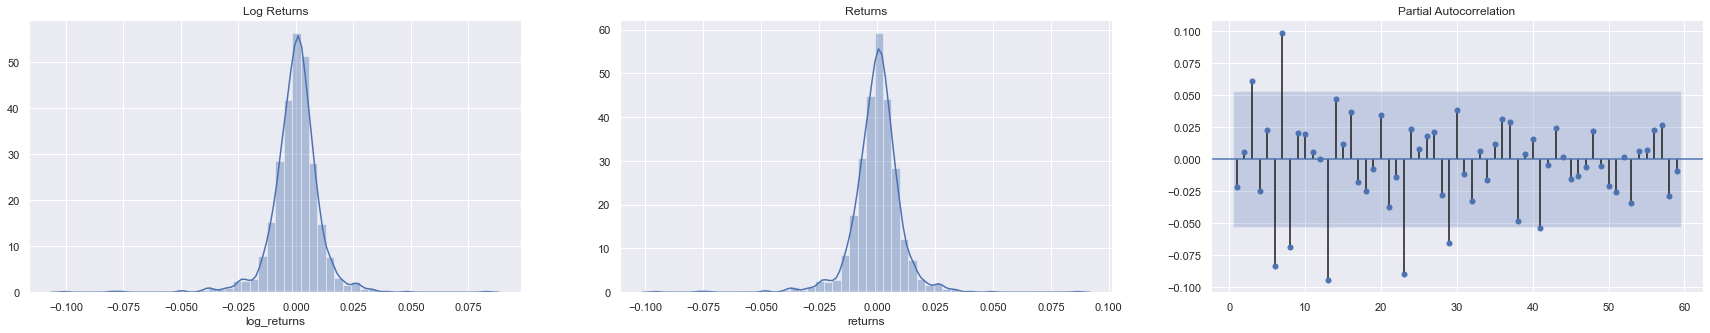

In [8]:
fullpath = f"../data/{datasets.value}.csv" #dataset
swap = False
df = pd.read_csv(fullpath)[['Date','Price','High','Low']]
df = clean(df)
df2, df3, normalizeFeats = transformDF(df, swap=swap)
statistics(df2)
df2 = df2.drop('returns',axis=1)
display(df2.tail())
display(df3.tail())


**Models**

This  fits the training data to several models and produces graphs
+ XGBoost (xgb), CatBoost (cb) (Gradient Boosted Decision Trees)
+ Logistic Regression (Logit) / Linear Regression (linear_reg)
+ Deep Neural Network (dnn) - finds  a relationship (joint distribution) between variables and target
+ Gaussian Process (gp) - learns a normal distribution over time

The general specification for the model

$ \hat y_{t+1} = f(x_{t},x_{t-1},... x_{t-L})$

Where $x_{t}$ is a vector of features, $x_{t} = (y_{t}, \text{log}(price),\text{log}(high),\text{log}(low), dateFeatures...)$


**PARAMETERS**
Parameters to set: 
+ **param:** what the model tries to forecast. 
    + **direction** - 0 or 1 for decrease, increase respectively (a probability) in close-to-close price (rate)
    + **log_returns** - Log-Change in close-to-close price (rate), > 0 means increase, < 0 means decrease
    + **Price**, **Rate** - next close price (rate)
    + **IntradayRange** - next np.log(High/Low), proxy for intraday vol
+ **train_end** - this will be when you want the backtest to start (and the end of training data)
+ **hyperParams** - model hyperparameters
+ **LAGS** - how much history (lookback window) to include

**Hyperparameters Framework**
+ Set **LAGS** according to the partial autocorrelation plot (see the chart in the cell above), select a lag that lies outside the confidence interval (shaded blue region)
+ If overfitting, select an earlier **train end**, this also increases the size of the backtest period and makes results more likely to be significant


In [ ]:
param = 'direction' #what you want to forecast
train_end = "2020-03-09" #when you want to start backtesting (and end of training data)
hyperParams = {"cb":{"n_estimators":300, #no. of trees
                     "max_depth":5, #decision splits
                     "learning_rate":0.1}, #sum learning_rate * tree decision
               "xgb":{"n_estimators":300,
                      "max_depth":5,
                      "learning_rate":0.1},
               "ensemble":{"n_estimators":100, #combine your model predictions, wisdom of the crowds
                          "max_depth":1,
                           "learning_rate":0.01
                          },
               "dnn":{"hidden_units":64},
               'kmeans':{"n_clusters":8}
              }
LAGS = 24

**Output**

The output of running this cell is some **summary statistics of the models performance on the training and test dataset (backtest)**

+ For Regression (returns, it will be **R2** and **Mean Squared Error** 
+ For Classification it will be **Accuracy** - did it the uptrends correct and downtrends correct and **Receiving Operator Curve score** (how good are your predicted probabilities, shld have as close to 0 if its actually 0 and as close to 1 if its actually 1) 



**Trade Recommendation Framework**
1. Do the models have above 50% accuracy?
2. Which models have above 50% accuracy?
3. Which models lead to a good backtest result?
4. Do the best models have a consensus view?
5. Take the best model's forecast


If not either...
1. Change hyperparametes and run again (training size, model hyperparameters, lags)
2. Discard predictions for today

MODEL EVALUATION - TRAINING SET
--------------------
Model: cbc
Model: xgbc
Model: logit
Model: gpc
Model: dnn
Model: ensemble
--------------------

MODEL EVALUATION - TEST SET
--------------------
Model: cbc
Model: xgbc
Model: logit
Model: gpc
Model: ensemble
Model: dnn


,train_accuracy,train_f1_score,train_roc_auc,test_accuracy,test_f1_score,test_roc_auc,hyperParams
logit,0.513097,0.678208,0.471419,0.521739,0.685714,0.227273,NaN
ensemble,1.000000,1.000000,1.000000,0.478261,0.400000,0.435606,"{""n_estimators"": 100, ""max_depth"": 1, ""learnin..."
cbc,1.000000,1.000000,1.000000,0.434783,0.518519,0.492424,"{""n_estimators"": 300, ""max_depth"": 5, ""learnin..."
xgbc,1.000000,1.000000,1.000000,0.434783,0.480000,0.363636,"{""n_estimators"": 300, ""max_depth"": 5, ""learnin..."
dnn,0.510015,0.174026,0.570932,0.434783,0.518519,0.401515,"{""hidden_units"": 64}"
gpc,1.000000,1.000000,1.000000,0.391304,0.416667,0.284091,NaN


LAST DATE: 2020-04-09
----------
FORECAST PROBABILITY OF INCREASE IN PRICE (0 means price very likely to decrease, 1 very likely to increase) 
----------
XGBoost Classifier: 0.60417
CatBoost Classifier 0.76702
Logit: 0.50976
Deep Neural Network: 0.25894
Gaussian Process: 0.50090
Ensemble: 0.51644


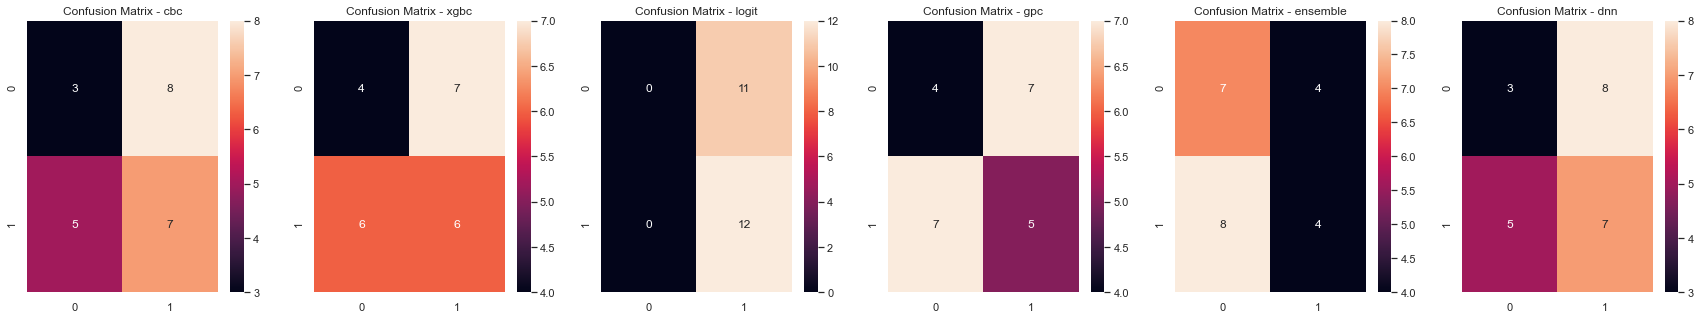

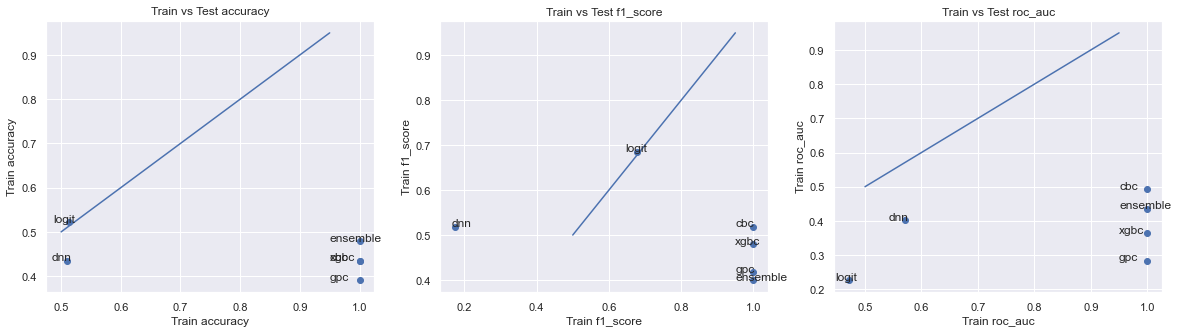

In [41]:
df4, df5 = addLaggedFeats(df2, df3, LAGS)
data_tree, data, models, fig3, fig4, logs3,ax = trainTestWrapper(df4, df5, 
                                                              train_end, param, 
                                                              normalizeFeats,hyperParams, LAGS)
fig3.show()
#fig4.show() if mode is regression
display(logs3)


preds = recommendTrade(data_tree, data, models, param, swap=False)

modelHistory = modelHistoricPredsWriter(preds)

**Backtest**

The backtest offers more validation into whether the model

We backtest a simple trading rules: 
+ Direction - If the model is confident of a higher closing price, we long (payers), if confident of  lower we short (receivers), otherwise we go to cash. We require the model to have a level of a confidence, and we set risk limits (proportion of strategy capital in long/payers and short/receivers)
+ Returns, Price, log_returns - If the model forecasts an increase then long/payers, otherwise short/receivers

**We first backtest the performance of the strat across models and differing confidence levels**

In [6]:
results = backtestLogger(models,data_tree,data,param, swap,verbose=False,write=False)
results = isSwap(results, swap)
display(results)

BACKTEST SEARCHER
--------------------
PARAMS - Model: cbc, Confidence:-1
PARAMS - Model: cbc, Confidence:0
PARAMS - Model: cbc, Confidence:0.25
PARAMS - Model: cbc, Confidence:0.5
PARAMS - Model: cbc, Confidence:0.75
PARAMS - Model: cbc, Confidence:0.9
NO TRADES MADE
PARAMS - Model: logit, Confidence:-1
PARAMS - Model: logit, Confidence:0
PARAMS - Model: logit, Confidence:0.25
PARAMS - Model: logit, Confidence:0.5
PARAMS - Model: logit, Confidence:0.75
NO TRADES MADE
PARAMS - Model: logit, Confidence:0.9
NO TRADES MADE
PARAMS - Model: dnn, Confidence:-1
PARAMS - Model: dnn, Confidence:0
PARAMS - Model: dnn, Confidence:0.25
PARAMS - Model: dnn, Confidence:0.5
PARAMS - Model: dnn, Confidence:0.75
NO TRADES MADE
PARAMS - Model: dnn, Confidence:0.9
NO TRADES MADE
PARAMS - Model: ensemble, Confidence:-1
PARAMS - Model: ensemble, Confidence:0
PARAMS - Model: ensemble, Confidence:0.25
PARAMS - Model: ensemble, Confidence:0.5
PARAMS - Model: ensemble, Confidence:0.75
NO TRADES MADE
PARAMS - M

,totalPNL,meanPNL,sharpe,max_drawdown,volatility,sortino,winRate,meanTime,no_of_trades,bestTrade,worstTrade,totalReturn,meanReturn,alpha,wins,completedTrades,pVal,model,confidence_level
0,37.282672,1.694667,-1.154992,-0.003939,0.001015,-1.601506,0.434783,2.0,23.0,25.557664,-10.053818,1.002890,1.000112,-0.019878,10.0,22.0,0.738266,xgbc,0.90
1,37.282672,1.694667,-1.154992,-0.003939,0.001015,-1.601506,0.434783,2.0,23.0,25.557664,-10.053818,1.002890,1.000112,-0.019878,10.0,22.0,0.738266,xgbc,0.75
2,37.282672,1.694667,-1.154992,-0.003939,0.001015,-1.601506,0.434783,2.0,23.0,25.557664,-10.053818,1.002890,1.000112,-0.019878,10.0,22.0,0.738266,xgbc,-1.00
3,37.282672,1.694667,-1.154992,-0.003939,0.001015,-1.601506,0.434783,2.0,23.0,25.557664,-10.053818,1.002890,1.000112,-0.019878,10.0,22.0,0.738266,xgbc,0.50
4,37.282672,1.694667,-1.154992,-0.003939,0.001015,-1.601506,0.434783,2.0,23.0,25.557664,-10.053818,1.002890,1.000112,-0.019878,10.0,22.0,0.738266,xgbc,0.25
5,37.282672,1.694667,-1.154992,-0.003939,0.001015,-1.601506,0.434783,2.0,23.0,25.557664,-10.053818,1.002890,1.000112,-0.019878,10.0,22.0,0.738266,xgbc,0.00
6,32.128566,5.354761,-0.572135,-0.001564,0.000595,-0.896047,0.666667,1.0,6.0,15.919675,-15.721340,1.004267,1.000164,-0.018501,4.0,6.0,0.343750,ensemble,0.50
7,30.499412,2.346109,-0.053806,-0.002412,0.000844,-0.082848,0.692308,1.0,13.0,36.361745,-20.531516,1.004747,1.000183,-0.018020,9.0,13.0,0.133423,cbc,0.50
8,28.759454,1.307248,-0.891853,-0.001845,0.000719,-1.238267,0.478261,2.0,23.0,10.113617,-6.817910,1.003770,1.000145,-0.018998,11.0,22.0,0.584094,ensemble,0.00
9,28.309124,1.286778,-0.186367,-0.002347,0.000886,-0.274223,0.565217,1.0,23.0,20.795523,-18.920331,1.004550,1.000175,-0.018218,13.0,22.0,0.261734,cbc,0.00


# After finding the model + confidence that leads to the best backtest result 

We run the backtest again for the specific model for a futher deeper dive.


We can then visualise any trade given a valid trade ID in the tradeBook


You can set the following parameters:
+ **starting_cap** - Initial Capital
+ **longLimit** - limit on Longs as a proportion of strategy capital (between 0 or 1) 
+ **shortLimit** - limit on Shorts as a proportion of strategy capital (between 0 or 1) 
+ **longLimit** - limit on Longs as a proportion of strategy capital (between 0 or 1)
+ **confidence** - how sure you want to be of a forecast (between 0 or 1) or -1 for no sizing
+ **reinvest** - reinvest capital
+ **swap** - is it a swap
+ **write** - whether you want to output a record of trades
+ **path** - where you want to write your files to





In [4]:
backtestResults,tradeBook = backtest(models, data_tree, data, 
                           transaction_costs=0, starting_cap = 10000,
                           modelToUse='ensemble', param=param, swap=swap,
                            confidence=0.25, longLimit=1, shortLimit=-1,reinvest=False, 
                           write=False, path = "")

fig, fig2, summary = diagnoseBackTest(backtestResults, 
                                    tradeBook, 
                                    data['date_test'],
                                     swap=swap,starting_cap=10000,verbose=True)
fig.show()
fig2.show()
tradeBook2 = isSwap2(tradeBook,swap)
tradeBook

tradeBook
fig = tradeBookPlotter(2, tradeBook, data_tree)
fig.show()

BACKTEST SUMMARY
--------------------
UNITS: NOTATIONAL
Number of Trades: 17
WIN RATE: 70.58824% (Statistical Significance/ p-value : 0.0384063720703125) 
TOTAL PNL: 1961.51 (0.00011885543373417215)
MEAN PNL per trade: 122.59 (0.00010079479286930368)
Maximum Drawdown: -1.43028 %
Volatility: 0.01178
Sharpe: 10.46406
Sortino: 41.18832
Alpha (excess on benchmark): -0.54491
Mean Duration of Trade: 1
Best Trade: 582.96 (0.06)
Worst Trade: -11.16 (0.06)
--------------------



## Feature Importances
This is a way to explain how the model comes to a decision. It shows how much the model utilises a particular feature (variable)

## Shapley Values

This is a way to explain how the model comes to a decision. It shows how the relative highness/lowness of a feature impacts the model output. It is useful particularly in the Neural Network (black box cases), if you want to get an explanation for how the model works. https://github.com/slundberg/shap

LAST DATE: 2020-04-08
----------
FORECAST PROBABILITY OF INCREASE IN PRICE (0 means price very likely to decrease, 1 very likely to increase) 
----------
XGBoost Classifier: 0.37727
CatBoost Classifier 0.42653
Logit: 0.62275
Deep Neural Network: 0.66737
Gaussian Process: 0.55948
Ensemble: 0.49621


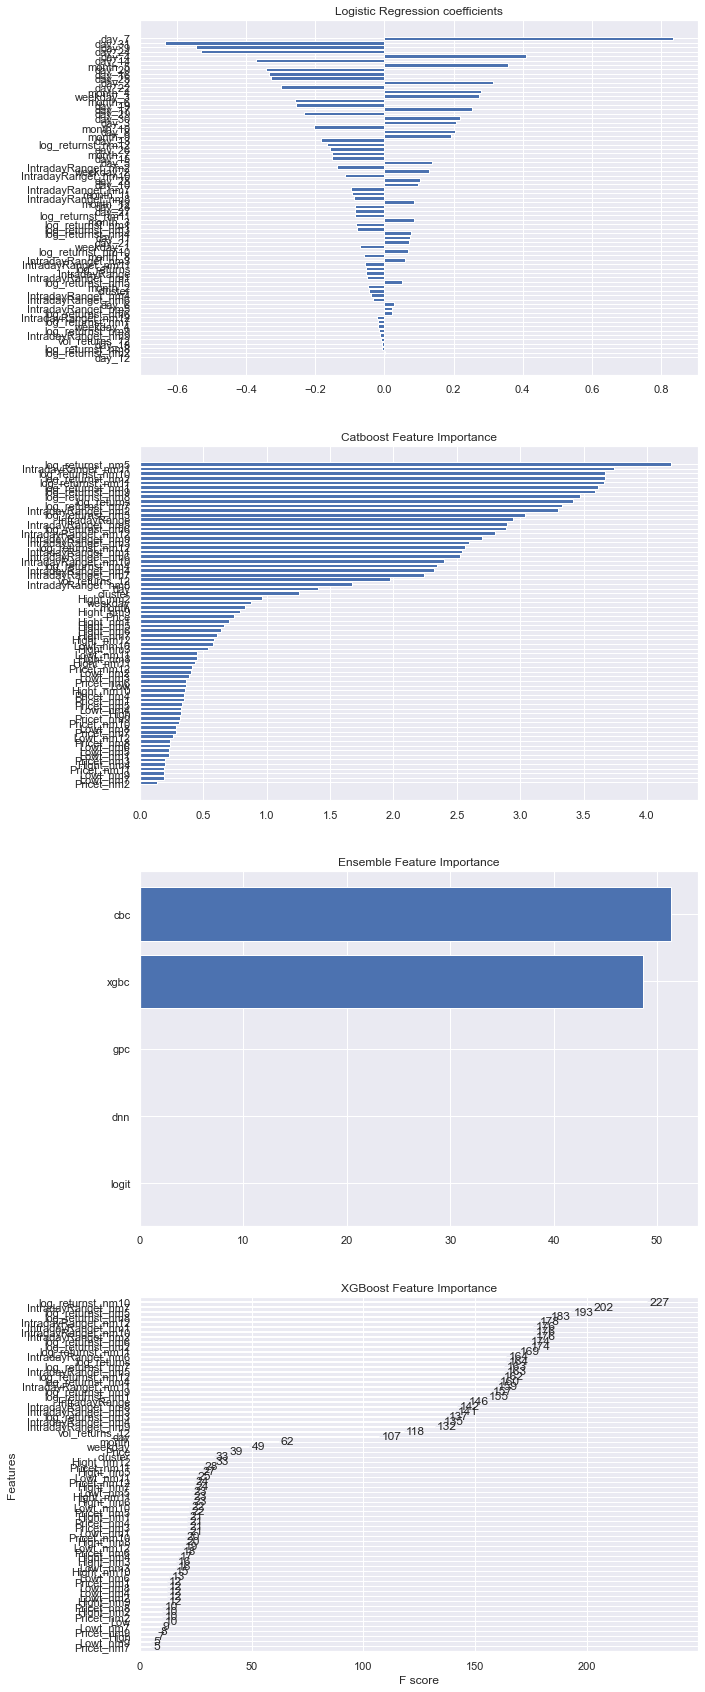

In [51]:
#feature importances
featImportances(models,data_tree, data, param)
#shapley values
shapPlotter(models, 'dnn', data_tree,data)

# Bet Sizing = 2p-1 - This makes high conviction forecast downs full shorts; high conviction ups longs

# Dev
+ Hypothesis Testing on Means, Residuals, Test for Normality
+ Residual analysis
+ Add lagged indicators
+ Multiple Comparison Bias